In [1]:
# Scientific libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')
from pyipn.io.plotting.projection import *
#import stan_utility

import cmdstanpy
import arviz as av
green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"

import os

import ipyvolume as ipv

from pyipn import copy_template, Universe, get_stan_model, plot_stan_fit

In [2]:
uni = Universe.from_yaml('template_3.yaml')
uni.explode_grb(tstart=-50,tstop=100)
print(uni._T0)
uni.plot_all_annuli(cmap='rainbow',lw=1, threeD=True);

[0.         0.10976842]


<IPython.core.display.Javascript object>


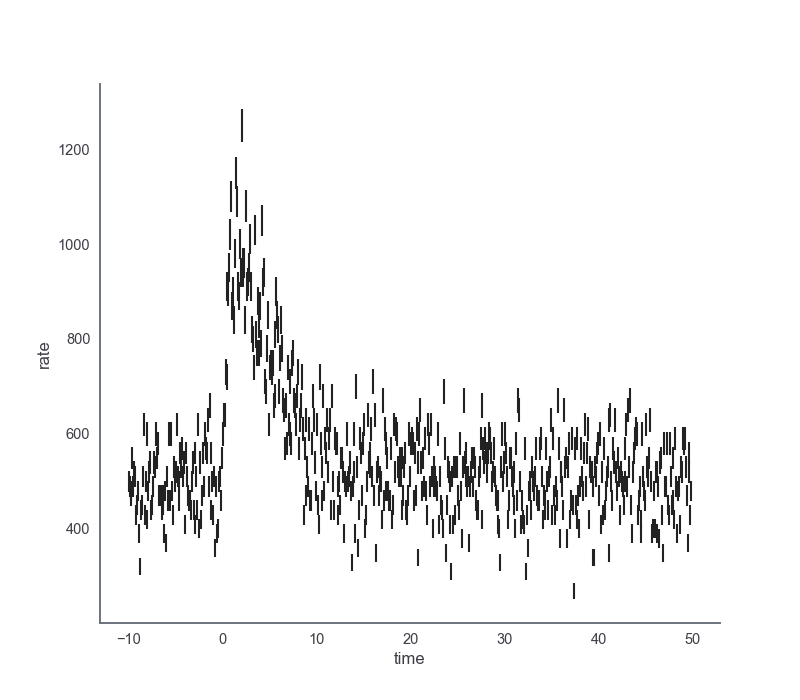

<IPython.core.display.Javascript object>


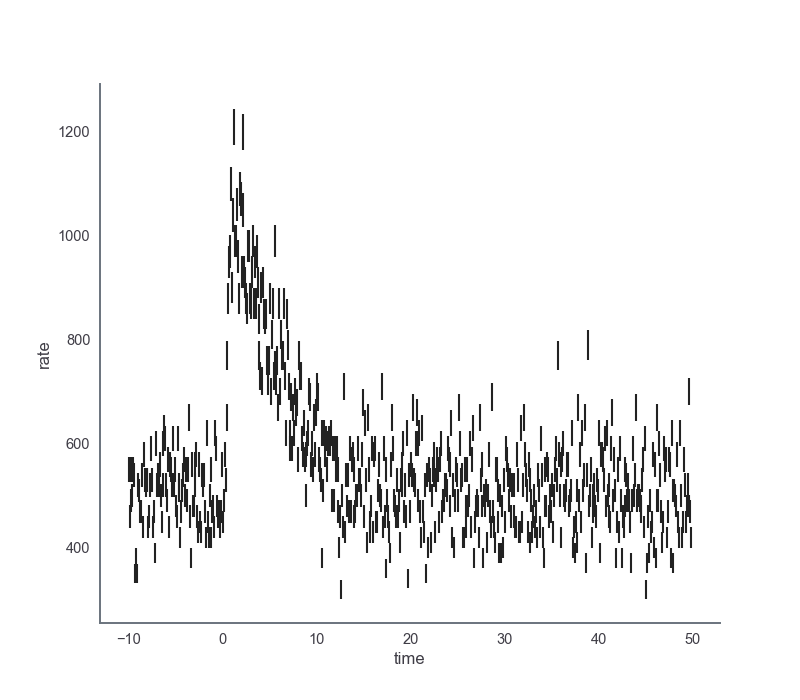

In [4]:
for det, lc in uni.light_curves.items():
    
    lc.display(-10,50,.1)
    #c, t = lc.get_binned_light_curve(-10, 50, .5)
    

In [16]:
class BinnedLightCurve(object):
    def __init__(self, counts, time_bins, tstart, tstop , dt):
        
        assert len(counts) == len(time_bins) - 1
        assert dt >0
        
        self._counts = counts
        self._time_bins = time_bins
        self._dt = dt
        self._tstart = tstart
        self._tstop = tstop
        self._n_bins = len(counts)
        
        
    @property
    def counts(self):
        return self._counts
    
    @property
    def time_bins(self):
        return self._time_bins
    
    @property
    def dt(self):
        return self._dt
    
    @property
    def tstart(self):
        return self._tstart
    
    @property
    def tstop(self):
        return self._tstop
    
    @property
    def n_bins(self):
        return self._n_bins
    
    
    @classmethod
    def from_lightcurve(cls, lightcurve, tstart, tstop, dt):
        
        _, t, c = lc.get_binned_light_curve( tstart, tstop, dt)
        
        return cls(c, t, tstart, tstop, dt)
        
        
        
        

In [17]:
def cross_correlate(lightcurve1, lightcurve2, bkg_rate=50.):
    
    
    bkg_sub_counts1 = lightcurve1.counts - bkg_rate * lightcurve1.dt
    
    bkg_sub_counts2 = lightcurve2.counts - bkg_rate * lightcurve2.dt

    
    
    s = bkg_sub_counts1.sum()/bkg_sub_counts2.sum()
    
    lag = []
    
    R2 = []
    
    for k in range(lightcurve1.n_bins):
        tmp = 0
        for i in range(lightcurve2.n_bins):
            if i+k >= lightcurve1.n_bins:
                break
            
            tmp+= (bkg_sub_counts2[i] - s*bkg_sub_counts1[i+k])**2/(lightcurve2.counts[i] + s**2 * lightcurve1.counts[i+k])
            
        
        
        tmp2 = lightcurve1.time_bins[0] - lightcurve2.time_bins[0+k]
        lag.append(tmp2)
        R2.append(tmp)
        
        if tmp2 < -3:
            break
            
    
        
    return R2, lag
            
    
    
    
    
    
    
    
    

<IPython.core.display.Javascript object>


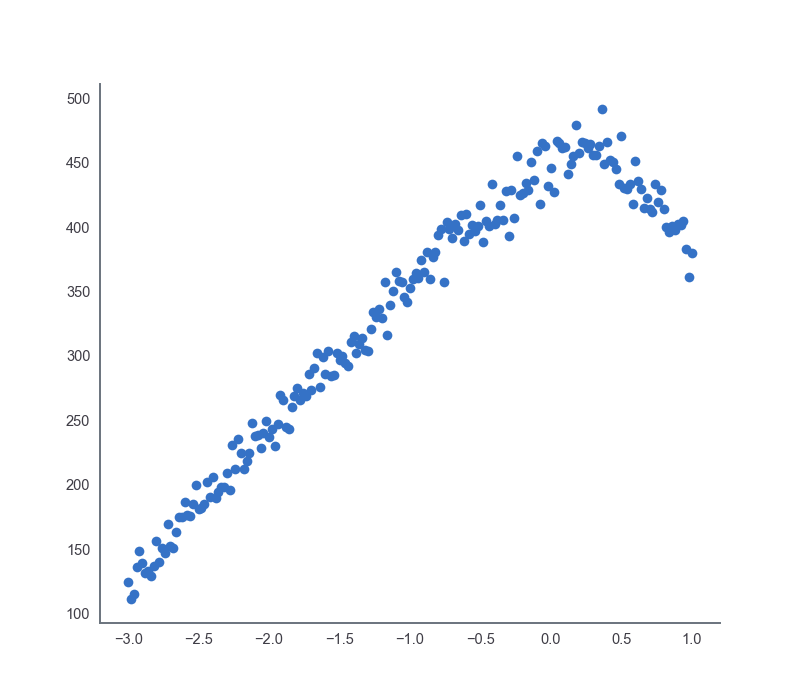

In [24]:
blc1 = BinnedLightCurve.from_lightcurve(uni.light_curves["det3"],-0,5,dt=.02)
blc2 = BinnedLightCurve.from_lightcurve(uni.light_curves["det2"],-1,5,dt=.02)
R2, lag = cross_correlate(blc1,blc2, bkg_rate=500.)
    
fig, ax = plt.subplots()

ax.plot(lag,R2,"o")

<IPython.core.display.Javascript object>


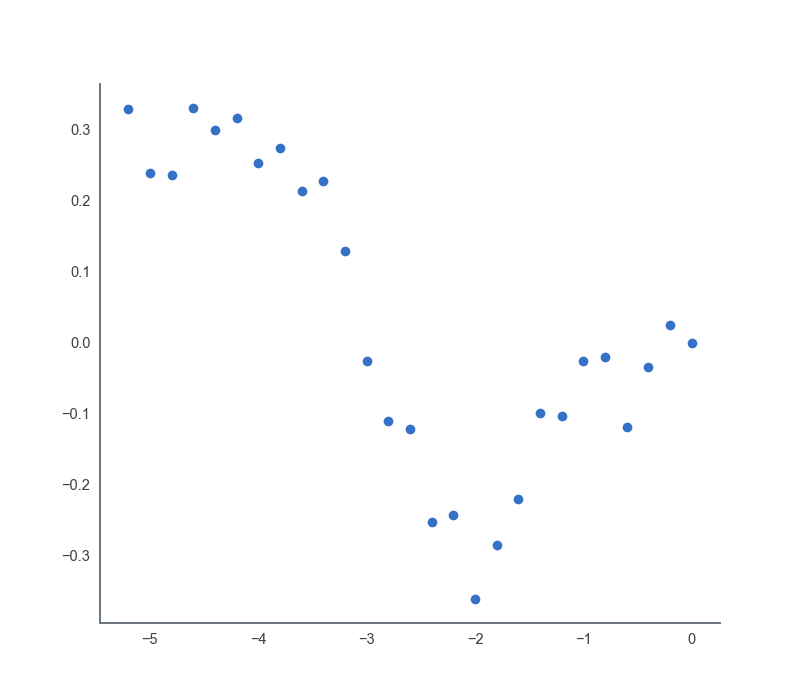

<IPython.core.display.Javascript object>


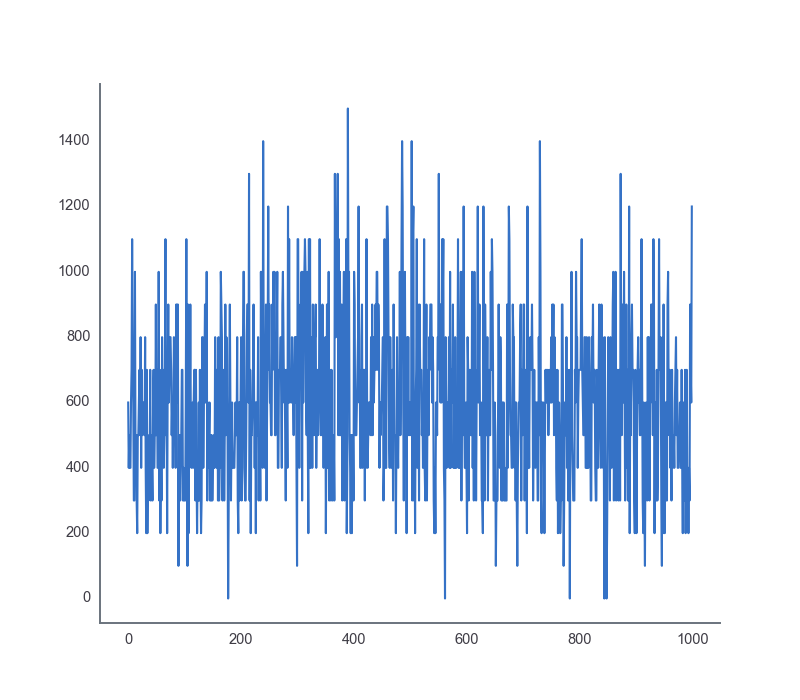

In [83]:
fig, ax = plt.subplots()

ax.plot(blc1.counts - 500 * blc1.dt)